<a href="https://colab.research.google.com/github/LeandroMurillo/TrabajoFinalPDS/blob/filtro-pasabajos/TFI_PDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Inicialización del repositorio**

In [789]:
from google.colab import userdata
import os

# === CONFIGURACIÓN ===
REPO_URL = "https://github.com/LeandroMurillo/TrabajoFinalPDS.git"
REPO_DIR = "/content/TrabajoFinalPDS"

# === Paso 1: Obtener token seguro desde secretos de Colab ===
token = userdata.get('GITHUB_TOKEN')
assert token, "⚠️ Agregá tu token en 'Entorno de ejecución > Gestionar secretos del entorno de ejecución'."

# === Paso 2: Clonar el repositorio si no existe ===
if not os.path.exists(REPO_DIR):
    os.chdir("/content")
    !git clone https://{token}@github.com/LeandroMurillo/TrabajoFinalPDS.git

# === Paso 3: Ingresar al repo y configurar el remote para autenticación con token ===
os.chdir(REPO_DIR)
!git remote set-url origin https://{token}@github.com/LeandroMurillo/TrabajoFinalPDS.git

print("Repositorio listo. Ya podés trabajar con Git.")

Repositorio listo. Ya podés trabajar con Git.


**Inicialización de variables y declaración de funciones**

In [790]:
# === Configuración e inicialización ===

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks, iirfilter, filtfilt
from scipy.signal import buttap, cheb1ap, cheb2ap, ellipap, lp2bp_zpk

# === Parámetros generales ===
fs = 360  # Frecuencia de muestreo en Hz

# === Archivo de entrada ===
archivo_mat = "/content/TrabajoFinalPDS/ecg_signal.mat"

# === Cargar y extraer señales desde el archivo .mat ===
mat_data = scipy.io.loadmat(archivo_mat)

# Extraer y convertir a milivoltios
senal1 = mat_data["ecg_signal1"].squeeze() * 1000
senal2 = mat_data["ecg_signal2"].squeeze() * 1000
senal3 = mat_data["ecg_signal3"].squeeze() * 1000

# Agrupar señales para recorrer en bucles
senales = [senal1, senal2, senal3]


# === Función para graficar una señal completa en el dominio del tiempo ===
def graficar_senal_completa(senal, fs, titulo="Señal en el tiempo"):
    tiempo = np.arange(len(senal)) / fs
    plt.figure(figsize=(14, 4))
    plt.plot(tiempo, senal, label="Señal completa")
    plt.title(titulo)
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud [mV]")
    plt.grid(True)
    plt.xlim(0, tiempo[-1])
    plt.xticks(np.arange(0, tiempo[-1] + 1, 1))
    locs, _ = plt.yticks()
    plt.yticks(locs, [f"{val:.3f}" for val in locs])
    plt.legend()
    plt.show()


# === Función para graficar el espectro (FFT) en decibeles ===
def graficar_fft_db(senal, fs, titulo="FFT de la señal [dB]", fmax=None):
    N = len(senal)
    espectro = fft(senal) / (N / 2)  # normalización adecuada
    frecs = fftfreq(N, 1 / fs)
    idx = frecs > 0
    frecs = frecs[idx]
    espectro_db = 20 * np.log10(np.abs(espectro[idx]) + 1e-12)

    if fmax is None:
        fmax = fs / 2

    ymax = np.max(espectro_db)
    ymin = ymax - 60

    plt.figure(figsize=(14, 4))
    plt.plot(frecs, espectro_db, linewidth=1, label="Espectro (FFT)")
    plt.title(titulo)
    plt.xlabel("Frecuencia [Hz]")
    plt.ylabel("Magnitud [dB]")
    plt.grid(True)
    plt.xlim(0, fmax)
    plt.ylim(ymin, ymax + 5)
    plt.legend()
    plt.tight_layout()
    plt.show()


# === Función para graficar un ciclo PQRST completo ===
def graficar_un_ciclo(senal, fs, titulo="Un ciclo cardíaco (PQRST)"):
    altura_minima = 0.5 * (np.max(senal) - np.min(senal)) + np.min(senal)
    distancia_minima = int(0.25 * fs)
    picos, _ = find_peaks(senal, height=altura_minima, distance=distancia_minima)

    if len(picos) == 0:
        print("No se detectaron picos R.")
        return

    centro = picos[0]
    pre = int(0.2 * fs)
    post = int(0.4 * fs)
    inicio = max(0, centro - pre)
    fin = min(len(senal), centro + post)
    tiempo = np.arange(inicio, fin) / fs

    plt.figure(figsize=(14, 4))
    plt.plot(tiempo, senal[inicio:fin], label="Ciclo PQRST")
    plt.title(titulo)
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud [mV]")
    plt.grid(True)
    plt.legend()
    plt.show()


def graficar_polos_ceros(z, p, plano="s"):
    """
    Grafica los polos y ceros de un sistema dado en el plano especificado.

    Args:
        z (array-like): Ceros del sistema.
        p (array-like): Polos del sistema.
        plano (str): 's' para plano s (analógico), 'z' para plano z (digital).
    """
    plt.figure(figsize=(6, 6))
    plt.axhline(0, color="black", linewidth=1)
    plt.axvline(0, color="black", linewidth=1)

    plt.plot(np.real(p), np.imag(p), "x", label="Polos")
    plt.plot(np.real(z), np.imag(z), "o", label="Ceros")

    if plano == "z":
        # Dibuja círculo unitario para filtros digitales
        circulo = plt.Circle((0, 0), 1, color="gray", linestyle="--", fill=False)
        plt.gca().add_patch(circulo)
        plt.title("Plano z - Polos y ceros del sistema")
    else:
        plt.title("Plano s - Polos y ceros del sistema")

    plt.xlabel("Parte real")
    plt.ylabel("Parte imaginaria")
    plt.grid(True)
    plt.axis("equal")
    plt.legend()
    plt.tight_layout()
    plt.show()

def graficar_polos_ceros_analogico(tipo, orden, f0, bw):
    """
    Dibuja el diagrama de polos y ceros en el plano s para el filtro analógico especificado.

    tipo: 'butter', 'cheby1', 'cheby2', 'ellip'
    orden: orden del filtro
    f0: frecuencia central del notch (Hz)
    bw: ancho de banda (Hz)
    """

    w0 = 2 * np.pi * f0  # Frecuencia angular
    bw_rad = 2 * np.pi * bw  # Ancho de banda angular

    # Obtener prototipo pasa bajos analógico
    if tipo == "butter":
        z, p, k = buttap(orden)
    elif tipo == "cheby1":
        z, p, k = cheb1ap(orden, Ap)
    elif tipo == "cheby2":
        z, p, k = cheb2ap(orden, As)
    elif tipo == "ellip":
        z, p, k = ellipap(orden, Ap, As)
    else:
        raise ValueError("Tipo de filtro no reconocido.")

    # Transformación pasa banda centrada en f0
    z_b, p_b, k_b = lp2bp_zpk(z, p, k, wo=w0, bw=bw_rad)

    # Gráfico
    plt.figure(figsize=(6, 6))
    plt.axhline(0, color="black")
    plt.axvline(0, color="black")
    plt.plot(np.real(p_b), np.imag(p_b), "x", label="Polos")
    plt.plot(np.real(z_b), np.imag(z_b), "o", label="Ceros")
    plt.xlabel("Re(s)")
    plt.ylabel("Im(s)")
    plt.title(
        f"Plano s - Polos y ceros del filtro {tipo.upper()}\nOrden {orden}, notch en {f0} Hz"
    )
    plt.grid(True)
    plt.axis("equal")
    plt.legend()
    plt.show()

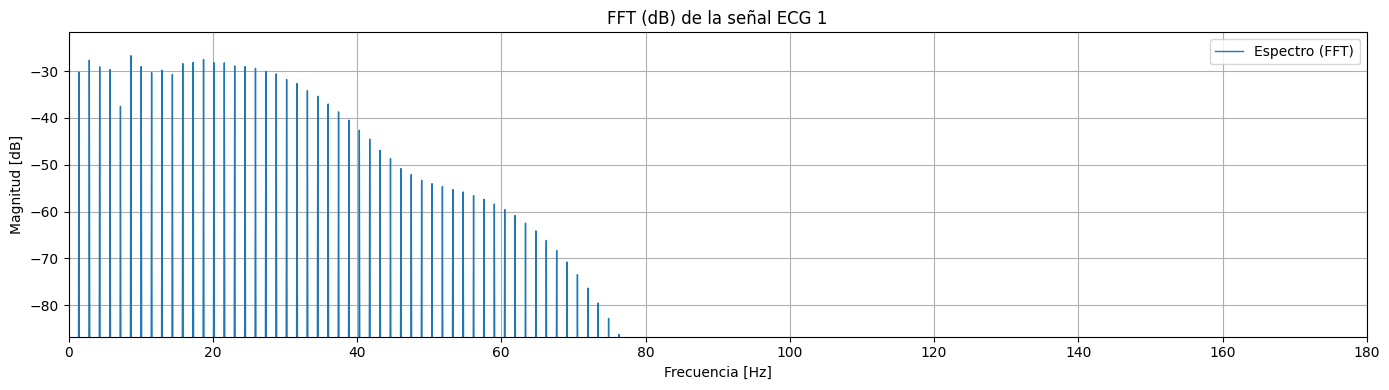

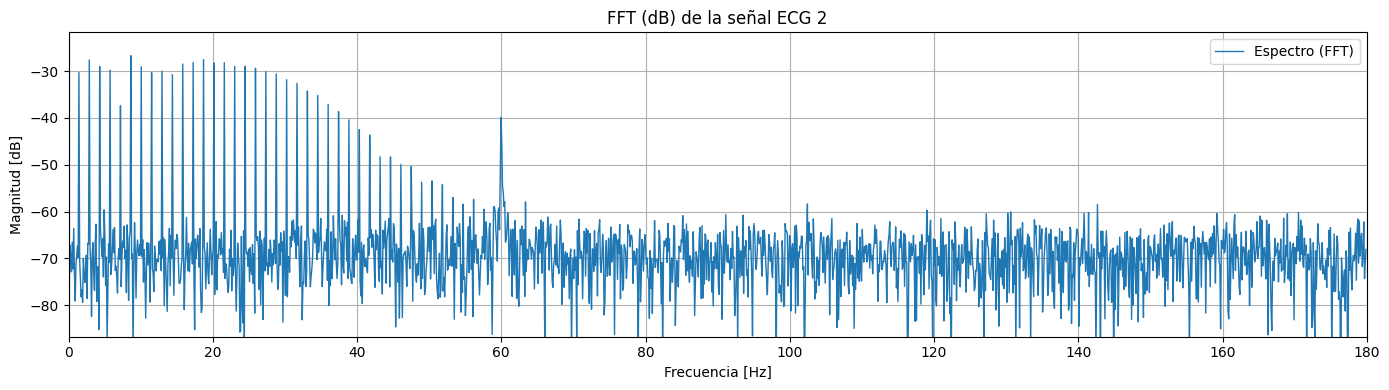

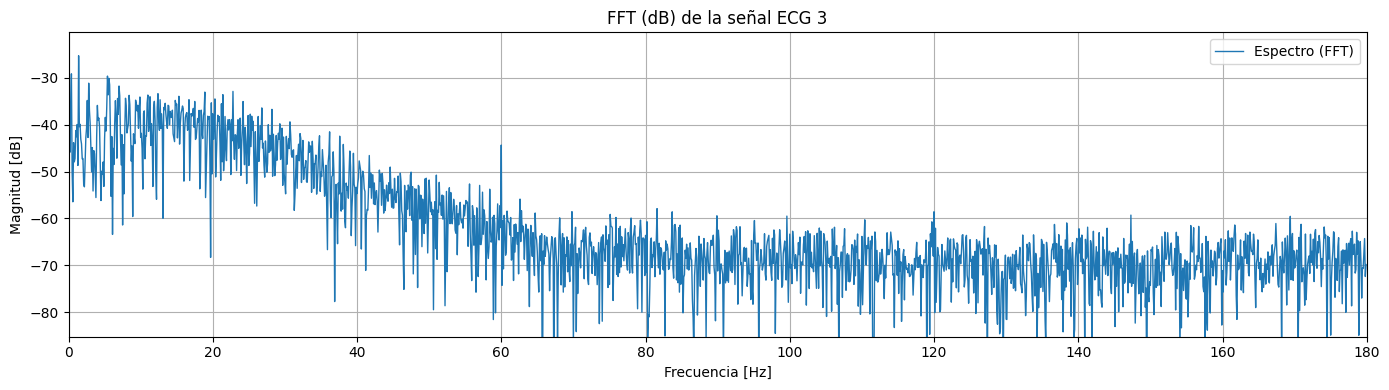

In [791]:
# === Graficar la FFT en decibeles de las tres señales ===
for i, senal in enumerate(senales, 1):
    graficar_fft_db(senal, fs, titulo=f"FFT (dB) de la señal ECG {i}")

In [792]:
# === Celda 2: Cálculo de órdenes mínimos para filtro Notch ===

from scipy.signal import buttord, cheb1ord, cheb2ord, ellipord


# === Función para calcular órdenes mínimos de cada tipo de filtro notch ===
def calcular_ordenes_notch(fp1, fp2, fs1, fs2, Ap, As, fs):
    """
    Calcula el orden mínimo necesario para filtros notch según especificaciones.

    Parámetros:
        fp1, fp2: Frecuencias de rechazo (Hz)
        fs1, fs2: Frecuencias de paso (Hz)
        Ap: Atenuación máxima en banda de paso (dB)
        As: Atenuación mínima en banda de rechazo (dB)
        fs: Frecuencia de muestreo (Hz)

    Devuelve:
        Diccionario con órdenes mínimos requeridos para cada tipo de filtro.
    """
    # Normalización respecto a Nyquist
    Wp = [fs1, fs2]
    Ws = [fp1, fp2]
    Wp_norm = [f / (fs / 2) for f in Wp]
    Ws_norm = [f / (fs / 2) for f in Ws]

    # Cálculo de órdenes
    ordenes = {}
    ordenes["butter"], _ = buttord(Wp_norm, Ws_norm, Ap, As)
    ordenes["cheby1"], _ = cheb1ord(Wp_norm, Ws_norm, Ap, As)
    ordenes["cheby2"], _ = cheb2ord(Wp_norm, Ws_norm, Ap, As)
    ordenes["ellip"], _ = ellipord(Wp_norm, Ws_norm, Ap, As)

    return ordenes


# === Parámetros de diseño notch según especificaciones ===
fp1 = 58  # Frecuencia de inicio de banda de rechazo [Hz]
fp2 = 62  # Fin de banda de rechazo [Hz]
fs1 = 57  # Fin de banda de paso antes del notch [Hz]
fs2 = 63  # Inicio de banda de paso después del notch [Hz]
Ap = 0.5  # Atenuación máxima en banda de paso [dB]
As = 40  # Atenuación mínima en banda de rechazo [dB]

# === Cálculo y muestra de órdenes mínimos ===
ordenes_notch = calcular_ordenes_notch(fp1, fp2, fs1, fs2, Ap, As, fs)

# Mostrar resultados
print("Órdenes mínimos requeridos para cada tipo de filtro Notch:")
for tipo, orden in ordenes_notch.items():
    print(f"  Filtro {tipo.upper()}: orden mínimo requerido = {orden}")

Órdenes mínimos requeridos para cada tipo de filtro Notch:
  Filtro BUTTER: orden mínimo requerido = 15
  Filtro CHEBY1: orden mínimo requerido = 7
  Filtro CHEBY2: orden mínimo requerido = 7
  Filtro ELLIP: orden mínimo requerido = 5


In [793]:
from scipy.signal import butter, cheby1, cheby2, ellip


# === Función para diseñar los filtros notch con cada tipo ===
def diseñar_filtros_notch(fp1, fp2, ordenes, Ap, As, fs):
    filtros = {}
    # Butterworth (¡ahora con frecuencia en Hz y fs explícito!)
    n = ordenes["butter"]
    filtros["butter"] = butter(n, [fp1, fp2], btype="bandstop", fs=fs)

    # Chebyshev I
    n = ordenes["cheby1"]
    filtros["cheby1"] = cheby1(n, Ap, [fp1, fp2], btype="bandstop", fs=fs)

    # Chebyshev II
    n = ordenes["cheby2"]
    filtros["cheby2"] = cheby2(n, As, [fp1, fp2], btype="bandstop", fs=fs)

    # Elíptico
    n = ordenes["ellip"]
    filtros["ellip"] = ellip(n, Ap, As, [fp1, fp2], btype="bandstop", fs=fs)

    return filtros


# === Aplicar la función ===
filtros_notch = diseñar_filtros_notch(fp1, fp2, ordenes_notch, Ap, As, fs)

# Verificación rápida (mostrar órdenes usados)
for tipo in filtros_notch:
    b, a = filtros_notch[tipo]
    print(f"{tipo.upper()}: filtro diseñado con orden = {len(a) - 1}")

BUTTER: filtro diseñado con orden = 30
CHEBY1: filtro diseñado con orden = 14
CHEBY2: filtro diseñado con orden = 14
ELLIP: filtro diseñado con orden = 10


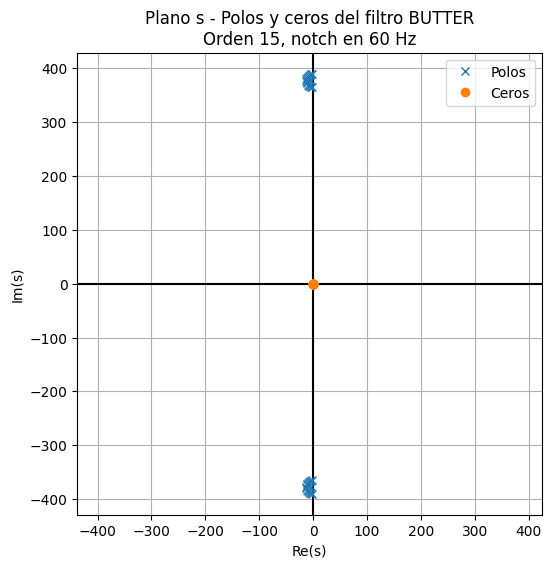

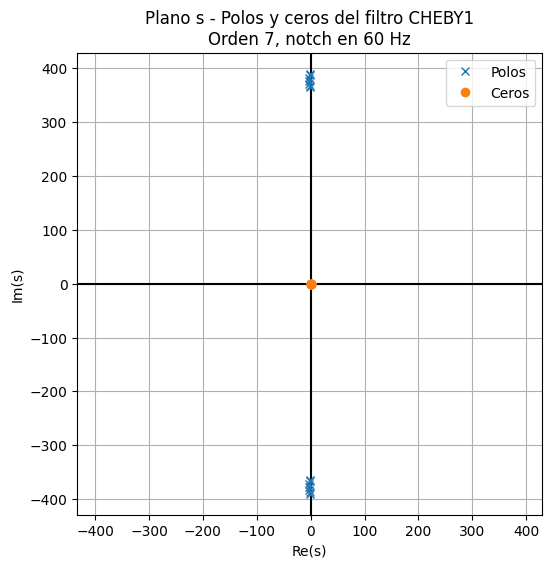

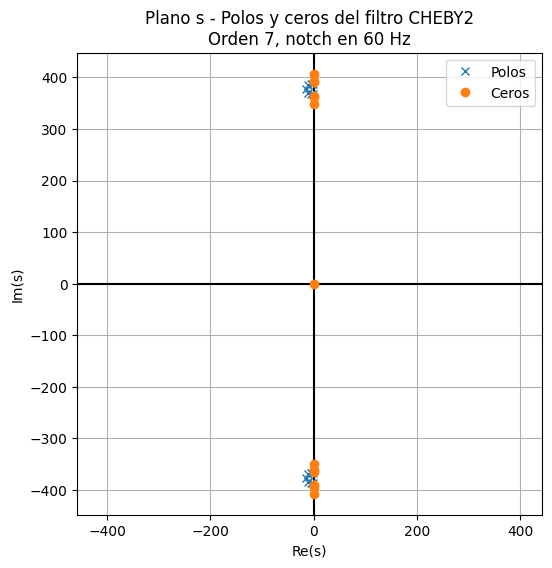

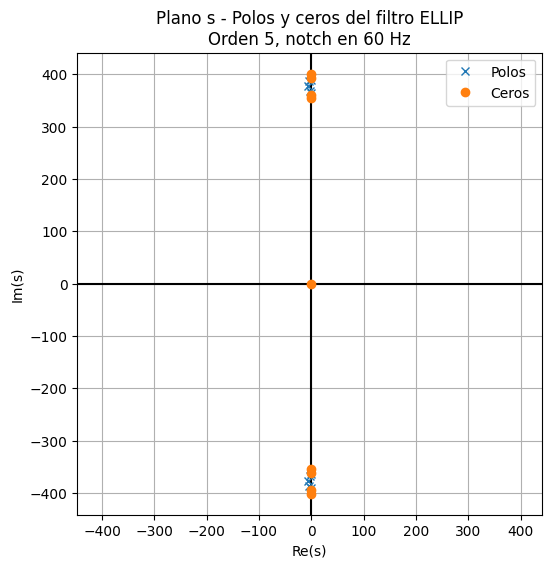

In [794]:
f0 = 60  # Frecuencia central del notch
bw = fp2 - fp1  # Ancho de banda

graficar_polos_ceros_analogico("butter", ordenes_notch["butter"], f0, bw)
graficar_polos_ceros_analogico("cheby1", ordenes_notch["cheby1"], f0, bw)
graficar_polos_ceros_analogico("cheby2", ordenes_notch["cheby2"], f0, bw)
graficar_polos_ceros_analogico("ellip", ordenes_notch["ellip"], f0, bw)

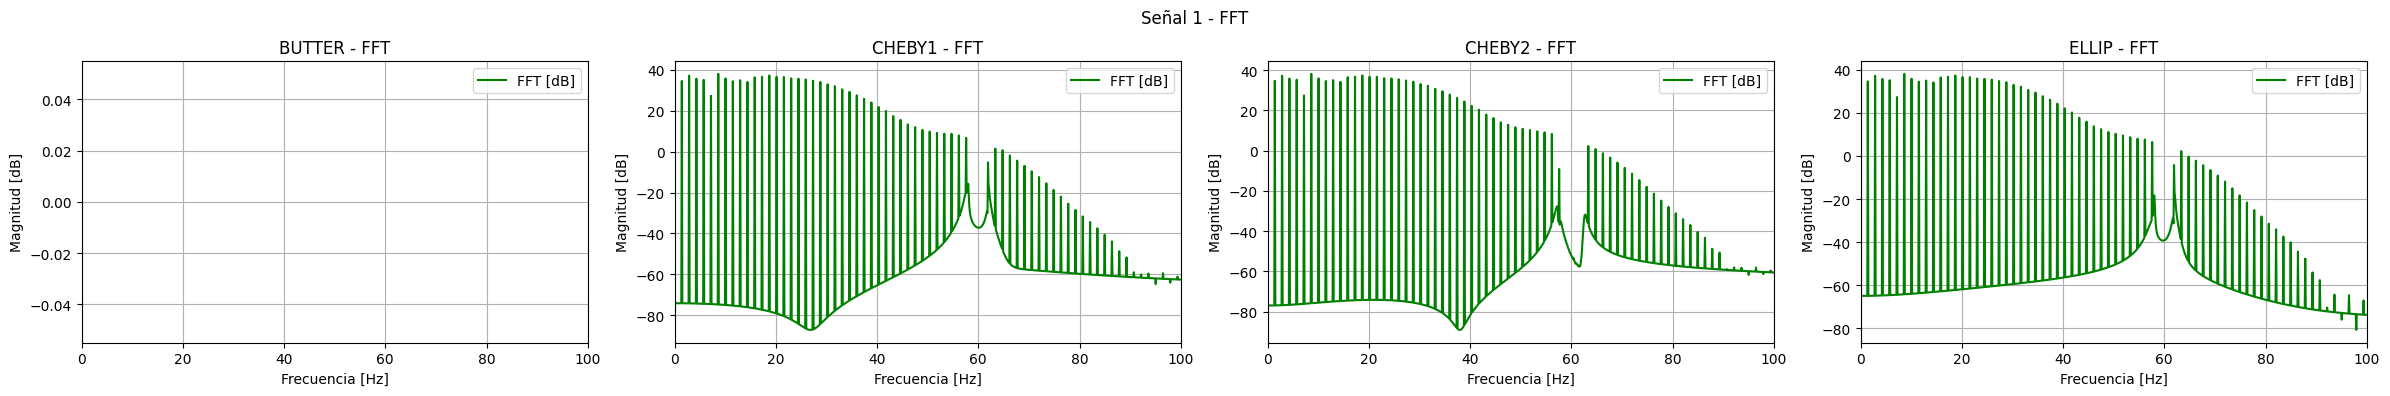

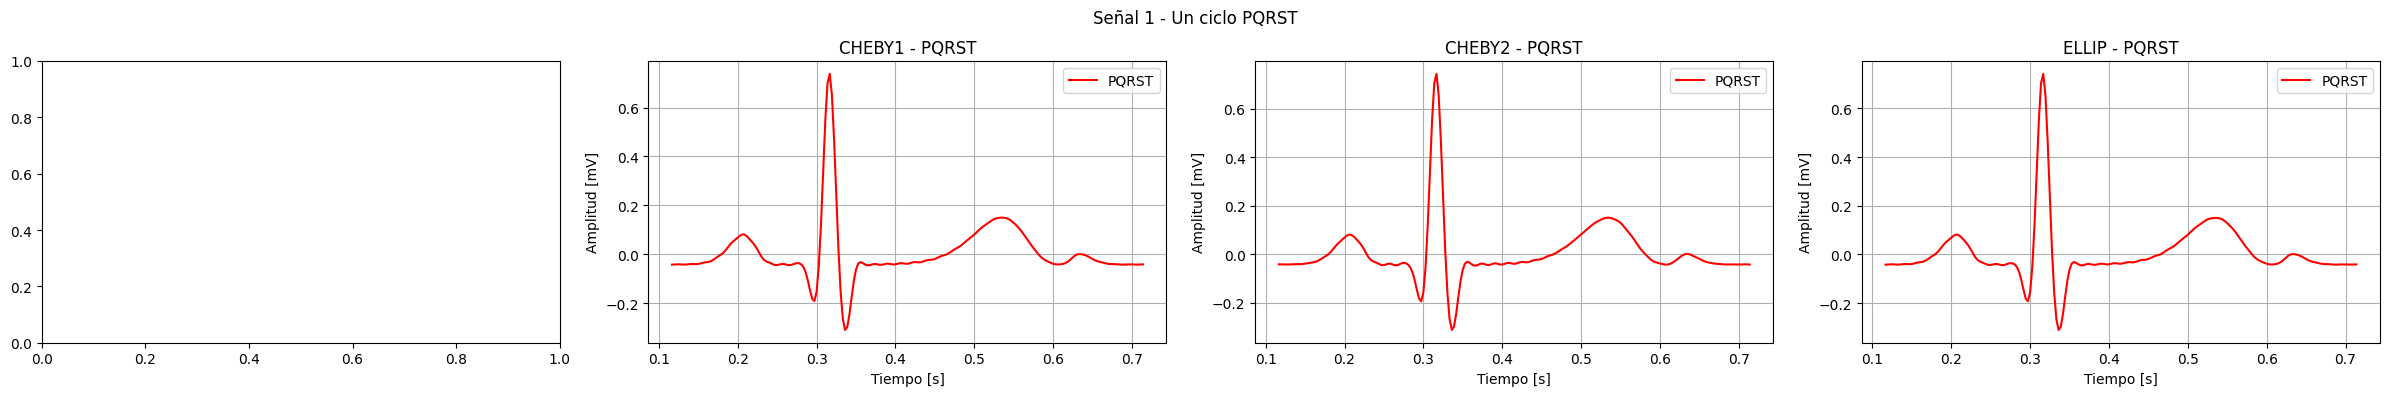

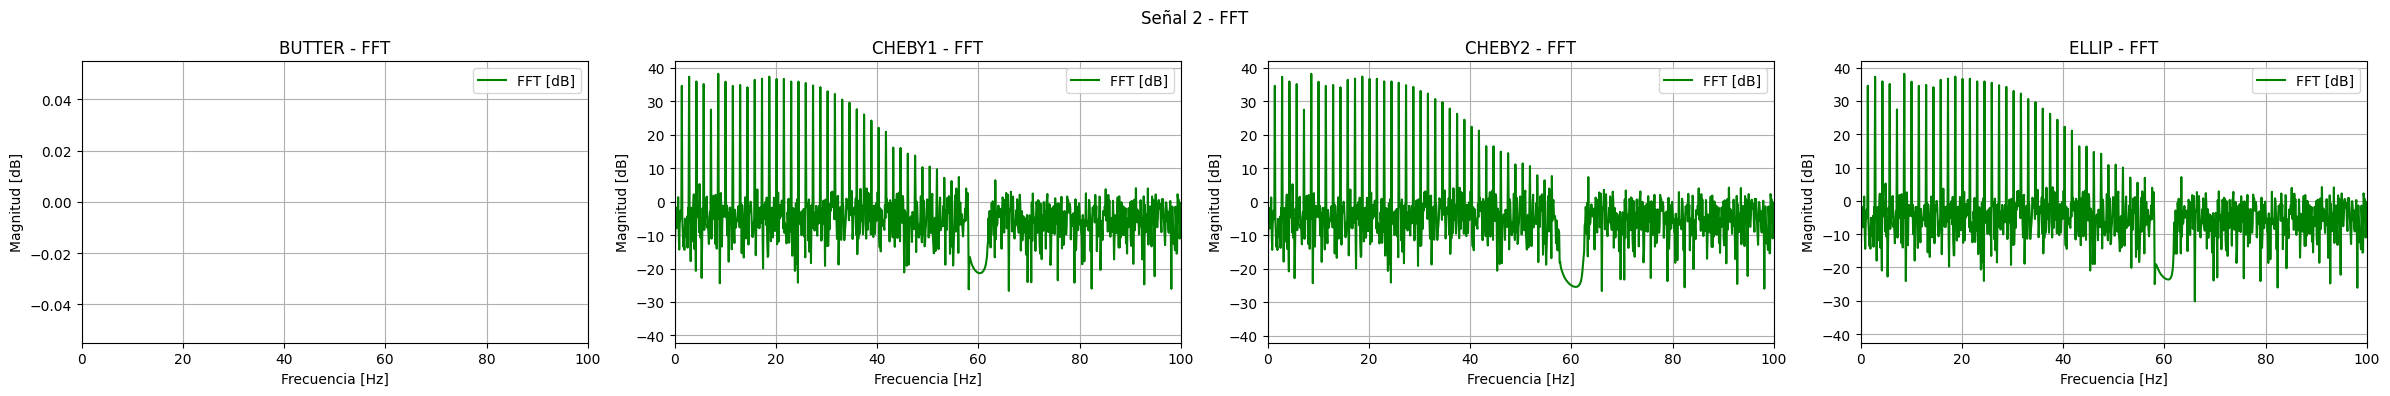

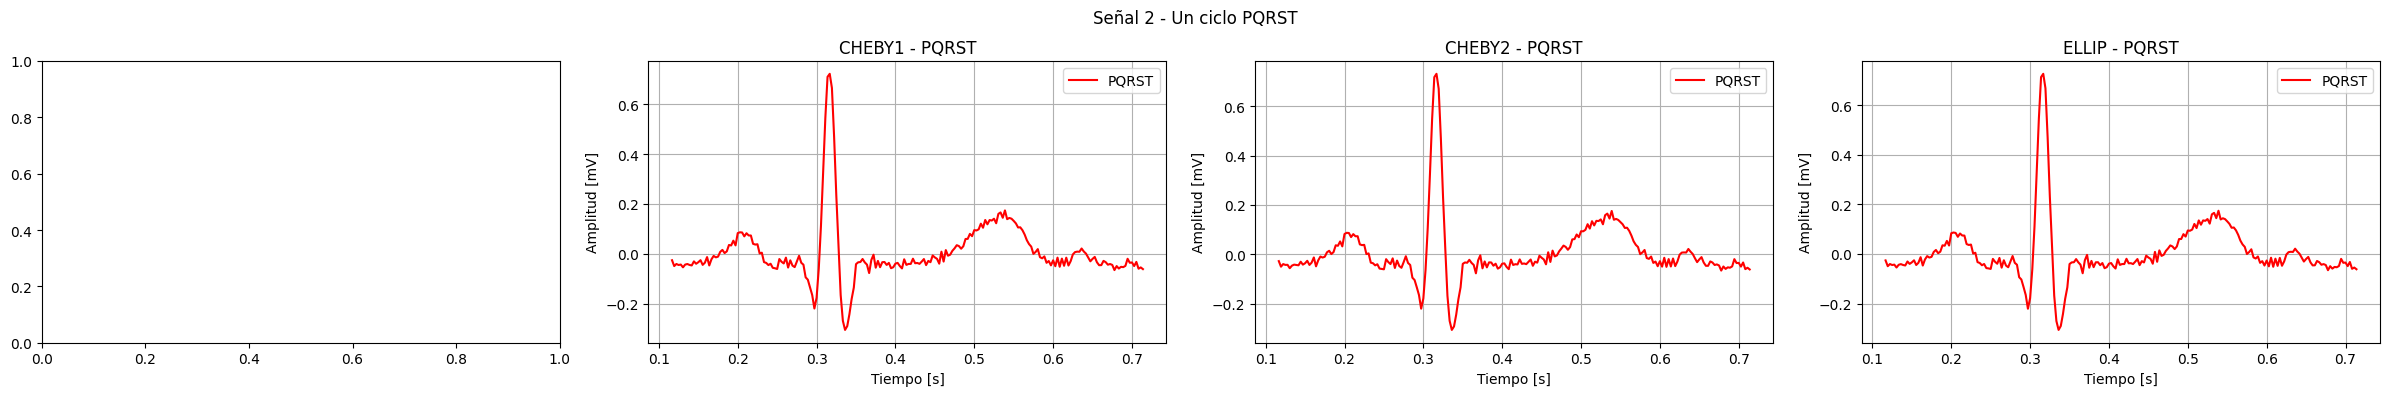

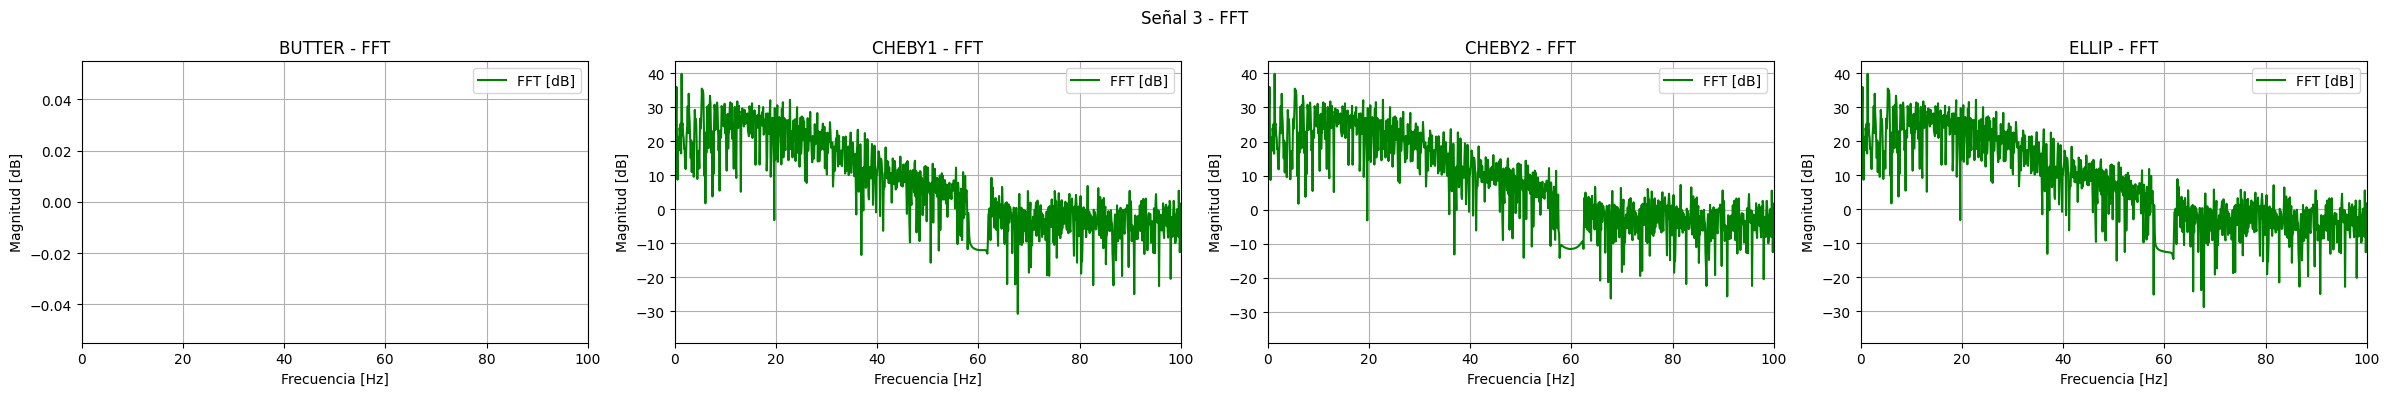

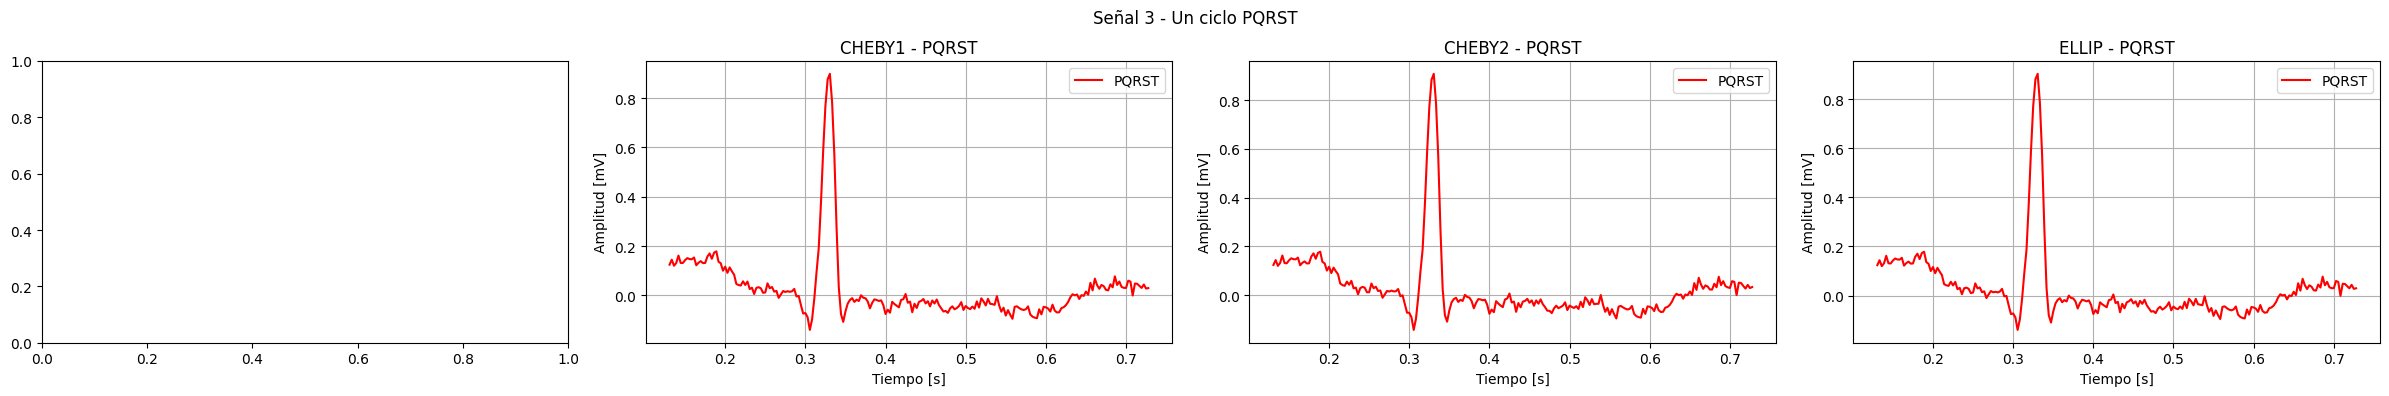

In [795]:
def comparar_filtros_notch(senal, filtros, fs, titulo_base=""):
    tiempo = np.arange(len(senal)) / fs

    # Crear figuras para FFT y ciclo PQRST (dos filas de gráficas)
    fig_fft, axs_fft = plt.subplots(1, len(filtros), figsize=(6 * len(filtros), 4))
    fig_pqrst, axs_pqrst = plt.subplots(1, len(filtros), figsize=(6 * len(filtros), 4))

    for i, (nombre, (b, a)) in enumerate(filtros.items()):
        salida = filtfilt(b, a, senal)  # hay que ver esta parte

        # === Espectro en dB ===
        N = len(salida)
        frecs = fftfreq(N, 1 / fs)
        idx = frecs > 0
        espectro = np.abs(fft(salida)[idx])
        espectro_db = 20 * np.log10(espectro + 1e-12)
        axs_fft[i].plot(frecs[idx], espectro_db, label="FFT [dB]", color="green")
        axs_fft[i].set_title(f"{nombre.upper()} - FFT")
        axs_fft[i].set_xlabel("Frecuencia [Hz]")
        axs_fft[i].set_ylabel("Magnitud [dB]")
        axs_fft[i].set_xlim(0, 100)
        axs_fft[i].grid(True)
        axs_fft[i].legend()

        # === Un ciclo PQRST ===
        altura_minima = 0.5 * (np.max(salida) - np.min(salida)) + np.min(salida)
        distancia_minima = int(0.25 * fs)
        picos, _ = find_peaks(salida, height=altura_minima, distance=distancia_minima)
        if len(picos) > 0:
            centro = picos[0]
            pre = int(0.2 * fs)
            post = int(0.4 * fs)
            inicio = max(0, centro - pre)
            fin = min(len(salida), centro + post)
            tiempo_ciclo = np.arange(inicio, fin) / fs
            axs_pqrst[i].plot(
                tiempo_ciclo, salida[inicio:fin], label="PQRST", color="red"
            )
            axs_pqrst[i].set_title(f"{nombre.upper()} - PQRST")
            axs_pqrst[i].set_xlabel("Tiempo [s]")
            axs_pqrst[i].set_ylabel("Amplitud [mV]")
            axs_pqrst[i].grid(True)
            axs_pqrst[i].legend()

    fig_fft.suptitle(f"{titulo_base} - FFT")
    fig_fft.tight_layout()
    fig_fft.subplots_adjust(top=0.85)
    fig_fft.show()

    fig_pqrst.suptitle(f"{titulo_base} - Un ciclo PQRST")
    fig_pqrst.tight_layout()
    fig_pqrst.subplots_adjust(top=0.85)
    fig_pqrst.show()


# === Llamar a la función para cada señal ===
for i, senal in enumerate(senales, start=1):
    comparar_filtros_notch(senal, filtros_notch, fs, titulo_base=f"Señal {i}")

FILTRO PASABAJOS ANALÓGICO

In [ ]:
from scipy.signal import buttord, butter, bilinear, freqz, freqs
import numpy as np
import matplotlib.pyplot as plt

fs = 360  # Frecuencia de muestreo en Hz

# === Frecuencias digitales deseadas (Hz)
fp = 30
fs_ = 90

# === Prewarping ===
wp = 2 * fs * np.tan(np.pi * fp / fs)  # rad/s
ws = 2 * fs * np.tan(np.pi * fs_ / fs)  # rad/s

# Atenuaciones (dB)
Ap = 0.5  # zona de paso
As = 10   # zona de rechazo

# === Diseño analógico ===
n, wn = buttord(wp, ws, Ap, As, analog=True)
print(f"Orden del filtro analógico: {n}")
print(f"Frecuencia wp (rad/s): {wp:.2f} ({wp / (2 * np.pi):.2f} Hz)")
print(f"Frecuencia ws (rad/s): {ws:.2f} ({ws / (2 * np.pi):.2f} Hz)")
print(f"Frecuencia de corte (rad/s): {wn:.2f} ({wn / (2 * np.pi):.2f} Hz)")

b, a = butter(n, wn, btype='low', analog=True)

In [ ]:
from scipy.signal import tf2zpk

# Obtener ceros y polos del filtro analógico
z, p, k = tf2zpk(b, a)

# Graficar en el plano s
graficar_polos_ceros(z, p, plano="s")

Coeficientes del filtro digital (bilineal):
bz = [0.11130076 0.22260152 0.11130076]
az = [ 1.         -0.86041723  0.30562026]

=== Especificaciones del Filtro Digital (Bilineal) ===
Frecuencia de paso (digital): 30.00 Hz
Frecuencia de rechazo (digital): 90.00 Hz


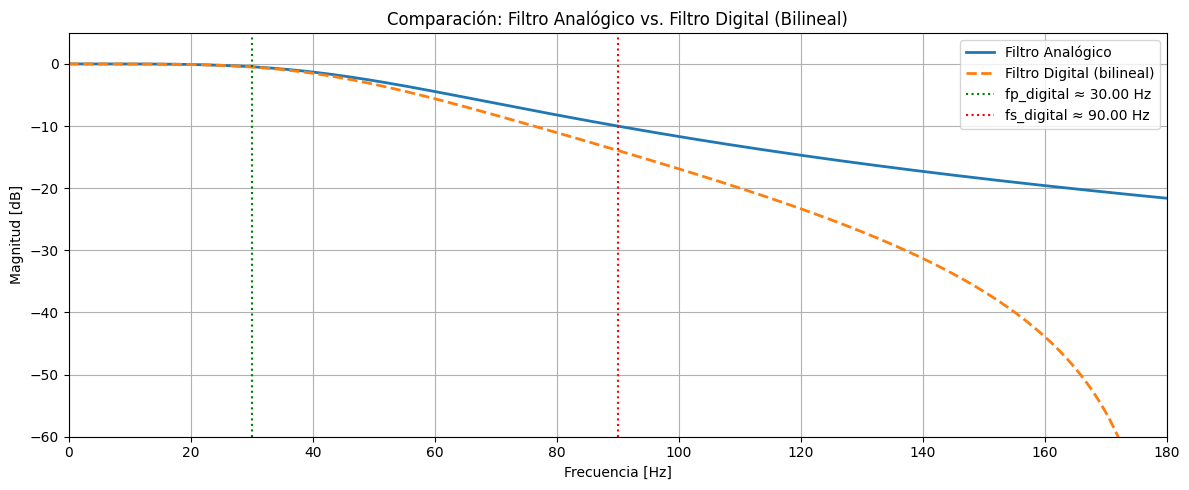

In [811]:
# === Transformación bilineal ===
bz, az = bilinear(b, a, fs)
print("Coeficientes del filtro digital (bilineal):")
print("bz =", bz)
print("az =", az)

# === Conversión inversa para obtener frecuencias digitales asociadas ===
fp_digital = (fs / np.pi) * np.arctan(wp / (2 * fs))
fs_digital = (fs / np.pi) * np.arctan(ws / (2 * fs))

print("\n=== Especificaciones del Filtro Digital (Bilineal) ===")
print(f"Frecuencia de paso (digital): {fp_digital:.2f} Hz")
print(f"Frecuencia de rechazo (digital): {fs_digital:.2f} Hz")

# === Respuesta en frecuencia del filtro analógico ===
w_analog = np.linspace(0.01, fs * np.pi, 1000)
frecs_analog = w_analog / (2 * np.pi)
_, h_analog = freqs(b, a, w_analog)
h_analog_db = 20 * np.log10(np.abs(h_analog))

# === Respuesta en frecuencia del filtro digital ===
w_digital, h_digital = freqz(bz, az, worN=1024)
frecs_digital = w_digital * fs / (2 * np.pi)
h_digital_db = 20 * np.log10(np.abs(h_digital))

# === Gráfico comparativo ===
plt.figure(figsize=(12, 5))
plt.plot(frecs_analog, h_analog_db, label="Filtro Analógico", linewidth=2)
plt.plot(frecs_digital, h_digital_db, "--", label="Filtro Digital (bilineal)", linewidth=2)
plt.axvline(fp_digital, color="green", linestyle=":", label=f"fp_digital ≈ {fp_digital:.2f} Hz")
plt.axvline(fs_digital, color="red", linestyle=":", label=f"fs_digital ≈ {fs_digital:.2f} Hz")
plt.title("Comparación: Filtro Analógico vs. Filtro Digital (Bilineal)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dB]")
plt.grid(True)
plt.xlim(0, fs / 2)
plt.ylim(-60, 5)
plt.legend()
plt.tight_layout()
plt.show()

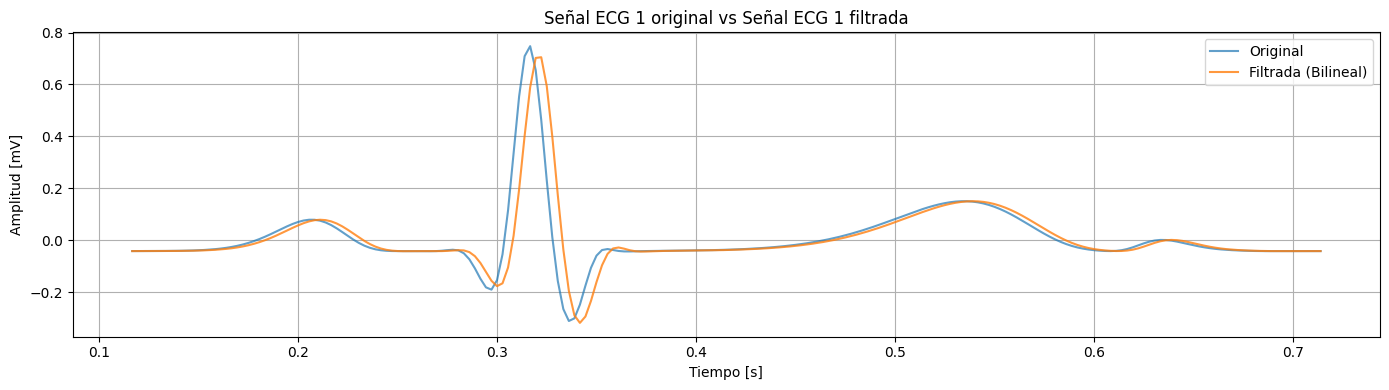

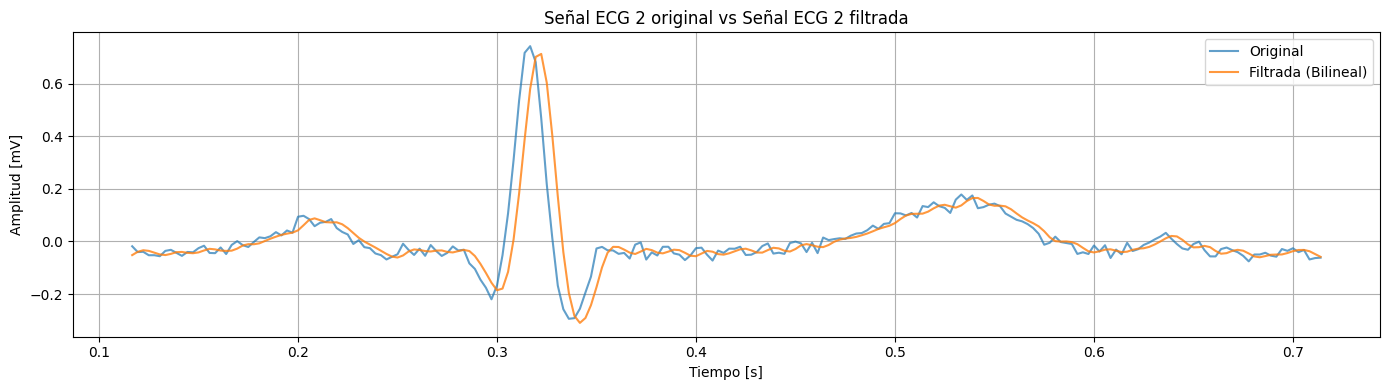

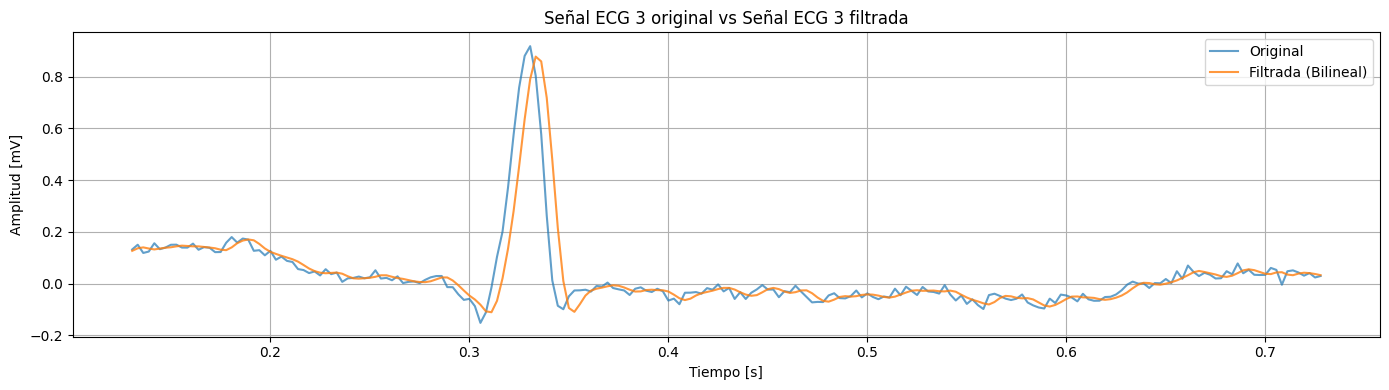

In [812]:
from scipy.signal import bilinear, lfilter, find_peaks
import matplotlib.pyplot as plt
import numpy as np

# === Aplicar el filtro y graficar un ciclo ===
senales_filtradas = []

for i, senal in enumerate(senales, 1):
    salida = lfilter(bz, az, senal)
    senales_filtradas.append(salida)

    # === Detección de un ciclo PQRST ===
    altura_minima = 0.5 * (np.max(senal) - np.min(senal)) + np.min(senal)
    distancia_minima = int(0.25 * fs)  # mínimo 250 ms entre picos
    picos, _ = find_peaks(senal, height=altura_minima, distance=distancia_minima)

    if len(picos) == 0:
        print(f"No se detectaron picos R en la señal {i}.")
        continue

    centro = picos[0]
    pre = int(0.2 * fs)
    post = int(0.4 * fs)
    inicio = max(0, centro - pre)
    fin = min(len(senal), centro + post)
    tiempo = np.arange(inicio, fin) / fs

    # === Gráfico de un solo ciclo: original vs filtrada ===
    plt.figure(figsize=(14, 4))
    plt.plot(tiempo, senal[inicio:fin], label="Original", alpha=0.7)
    plt.plot(tiempo, salida[inicio:fin], label="Filtrada (Bilineal)", alpha=0.8)
    plt.title(f"Señal ECG {i} original vs Señal ECG {i} filtrada")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud [mV]")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

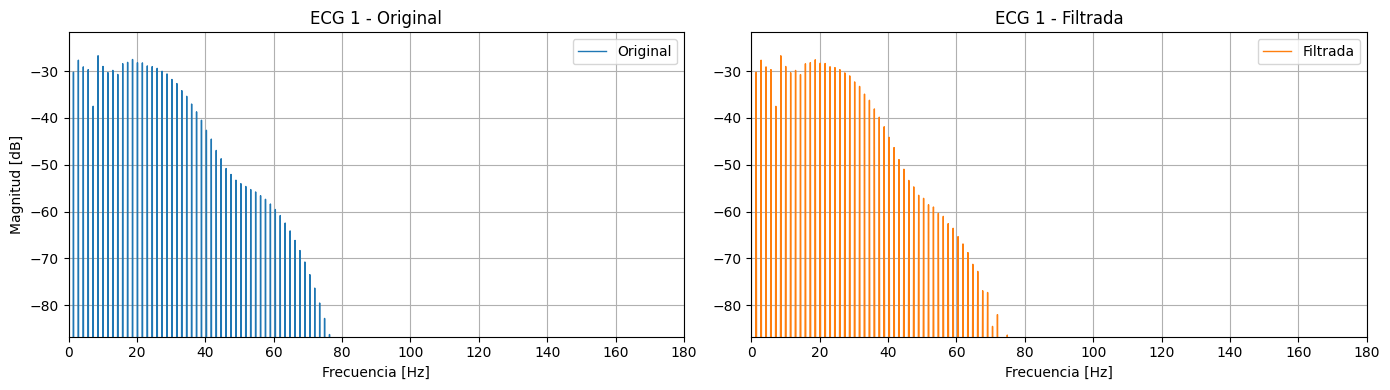

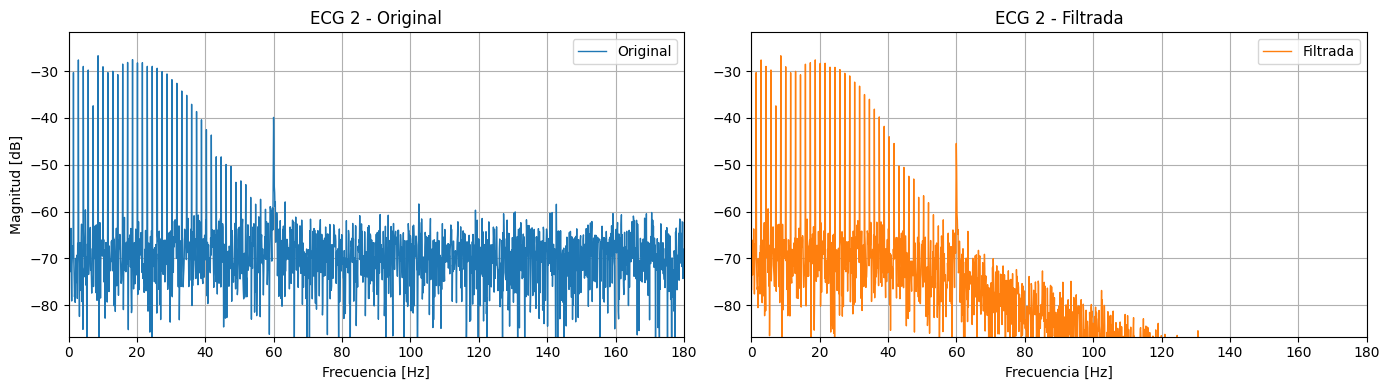

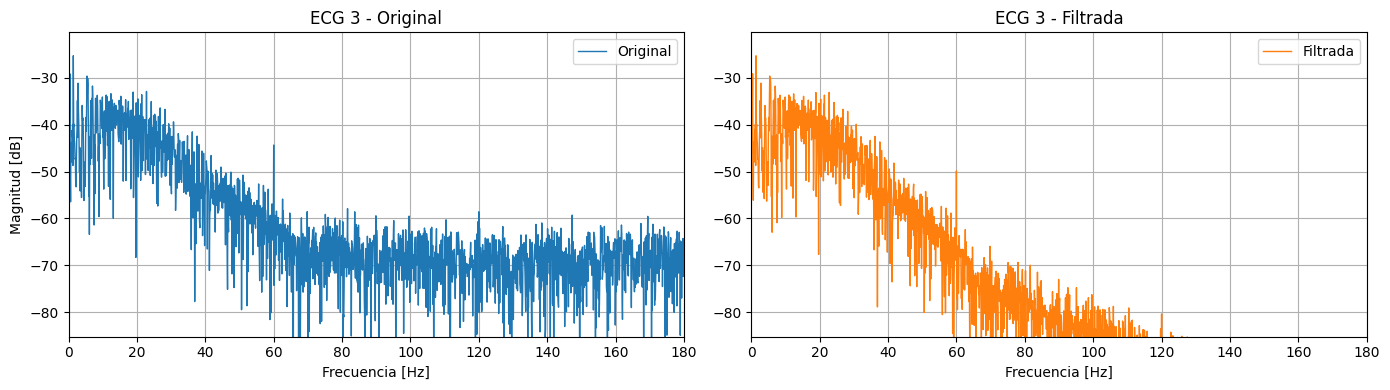

In [813]:
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
import numpy as np

# === Función adaptada para comparar espectros de señales original y filtrada ===
def graficar_fft_comparativa(senales, senales_filtradas, fs, fmax=None):
    for i, (senal, salida) in enumerate(zip(senales, senales_filtradas), 1):
        N = len(senal)
        espectro_orig = fft(senal) / (N / 2)
        espectro_filt = fft(salida) / (N / 2)
        frecs = fftfreq(N, 1 / fs)
        idx = frecs > 0
        frecs = frecs[idx]

        espectro_orig_db = 20 * np.log10(np.abs(espectro_orig[idx]) + 1e-12)
        espectro_filt_db = 20 * np.log10(np.abs(espectro_filt[idx]) + 1e-12)

        if fmax is None:
            fmax = fs / 2

        ymax = np.max(espectro_orig_db)
        ymin = ymax - 60

        plt.figure(figsize=(14, 4))

        # Espectro original
        plt.subplot(1, 2, 1)
        plt.plot(frecs, espectro_orig_db, linewidth=1, label="Original", color="tab:blue")
        plt.title(f"ECG {i} - Original")
        plt.xlabel("Frecuencia [Hz]")
        plt.ylabel("Magnitud [dB]")
        plt.grid(True)
        plt.xlim(0, fmax)
        plt.ylim(ymin, ymax + 5)
        plt.legend()

        # Espectro filtrado
        plt.subplot(1, 2, 2)
        plt.plot(frecs, espectro_filt_db, linewidth=1, label="Filtrada", color="tab:orange")
        plt.title(f"ECG {i} - Filtrada")
        plt.xlabel("Frecuencia [Hz]")
        plt.grid(True)
        plt.xlim(0, fmax)
        plt.ylim(ymin, ymax + 5)
        plt.legend()

        plt.tight_layout()
        plt.show()

# === Llamada a la función ===
graficar_fft_comparativa(senales, senales_filtradas, fs, fmax=180)


ACTIVIDAD 3 - PROCESAMIENTO EN TIEMPO REAL

In [801]:
import time
import numpy as np


def celda_segundo_orden(xn, coef, estado):
    """
    Aplica una celda de segundo orden (forma directa transpuesta II) a una muestra.

    Esta función implementa un filtro IIR de orden 2 sobre una única muestra, usando el
    estado interno del filtro y los coeficientes normalizados.

    Args:
        xn (float): Muestra de entrada actual.
        coef (tuple): Coeficientes del filtro en la forma (b0, b1, b2, a1, a2),
                      con a0 normalizado a 1.
        estado (list of float): Estado interno de la celda, como [w1, w2] (memorias).

    Returns:
        float: Muestra de salida filtrada.
    """
    b0, b1, b2, a1, a2 = coef
    w1, w2 = estado
    wn = xn - a1 * w1 - a2 * w2
    yn = b0 * wn + b1 * w1 + b2 * w2
    estado[1] = w1
    estado[0] = wn
    return yn


def filtro_cascada(xn, celdas_coef, estados):
    """
    Aplica una cadena de celdas de segundo orden en cascada a una muestra.

    Cada celda procesa la muestra secuencialmente, y su salida se convierte en la
    entrada de la siguiente celda. Esto permite implementar filtros complejos
    como combinaciones de filtros Notch, pasa bajos, etc.

    Args:
        xn (float): Muestra de entrada actual.
        celdas_coef (list of tuples): Lista de coeficientes (b0, b1, b2, a1, a2)
                                      para cada celda del filtro.
        estados (list of [float, float]): Lista de estados internos [w1, w2]
                                          para cada celda.

    Returns:
        float: Muestra de salida final después de pasar por todas las celdas.
    """
    for i in range(len(celdas_coef)):
        xn = celda_segundo_orden(xn, celdas_coef[i], estados[i])
    return xn


def procesar_senal(senal, celdas_coef):
    """
    Procesa una señal completa muestra a muestra mediante un sistema en cascada.

    La señal se procesa secuencialmente, aplicando cada muestra a todas las
    celdas del filtro en cascada. Se mide además el tiempo total de ejecución
    y el tiempo promedio por muestra, útil para evaluar rendimiento.

    Args:
        senal (array-like): Señal digital de entrada (1D).
        celdas_coef (list of tuples): Lista de coeficientes (b0, b1, b2, a1, a2)
                                      para cada celda en cascada.

    Returns:
        tuple:
            - np.ndarray: Señal de salida filtrada (misma longitud que la entrada).
            - float: Tiempo total de procesamiento (en segundos).
            - float: Tiempo promedio por muestra (en microsegundos).
    """
    estados = [[0.0, 0.0] for _ in celdas_coef]
    salida = []

    t0 = time.perf_counter()

    for xn in senal:
        yn = filtro_cascada(xn, celdas_coef, estados)
        salida.append(yn)

    t1 = time.perf_counter()

    tiempo_total = t1 - t0
    tiempo_por_muestra = tiempo_total / len(senal) * 1e6  # µs

    return np.array(salida), tiempo_total, tiempo_por_muestra